In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [70]:
def get_beta_DKL(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

def get_beta_end(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if Zlive/Zdead < epsilon:
        return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 100])
        return res.root
    except:
        return 0
    
def get_beta_start(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if Zlive/Zdead < epsilon:
        return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - 1/epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 100])
        return res.rootd
    except:
        return 0


def logprior(x, mu, sig):
    return -0.5*np.log(2*np.pi*sig**2) - np.power((x - mu)/sig, 2)/2

In [98]:
def logXf_dG_range(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_start = get_beta_start(points, ndead)
    beta_end = get_beta_end(points, ndead)
    beta_DKL = get_beta_DKL(points, ndead)
    logbeta_start, logbeta_end, logbeta_DKL = np.log([beta_start, beta_end, beta_DKL])
    betas = np.exp(np.linspace(logbeta_end, logbeta_DKL, 10))
    dG_range = points.d_G(nsamples=25, beta=betas)
    d_mean, d_std = dG_range.mean(), dG_range.std()
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(d_mean, d_std)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set)
    return logXf_set, f""

In [91]:
name, samples = get_samples('toy', 'cauchy_83')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

In [77]:
true_logXf

-106.58744804566055

In [99]:
ndead = 20000
points = model.points(ndead)
logL, X_mean, nk, logZdead = data(points)
logXf_dG_range(points, ndead, Nset=25)

/tmp/ipykernel_28227/4122241688.py:6: RuntimeWarning: divide by zero encountered in log
  logbeta_start, logbeta_end, logbeta_DKL = np.log([beta_start, beta_end, beta_DKL])


(array([-71.57215829, -80.81632581, -66.03064577, -78.13460031,
        -72.88889281, -81.94882328, -79.66668747, -73.28765881,
        -76.59114208, -64.60140886, -70.93773738, -91.09766464,
        -63.71635026, -85.83590409, -86.40488338, -76.39666809,
        -76.16400677, -88.15892714, -82.75456992]),
 '')

In [100]:
iterations = make_iterations(true_endpoint, 25, start=0.1)
logXfs, logXfs_set = model.logXfs(logXf_dG_range, iterations, Nset=25)

/tmp/ipykernel_28227/4122241688.py:6: RuntimeWarning: divide by zero encountered in log
  logbeta_start, logbeta_end, logbeta_DKL = np.log([beta_start, beta_end, beta_DKL])
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


Iteration 2988 of 28812, NaN


/home/zixiao/Documents/III/project/aeons/aeons/regress.py:29: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma_squared_analytic(d, Xdata, logLdata))
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:140: RuntimeWarning: invalid value encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/tmp/ipykernel_28227/3153407468.py:51: RuntimeWarning: overflow encountered in scalar divide
  return Zlive/Zdead - 1/epsilon
/tmp/ipykernel_28227/3153407468.py:27: RuntimeWarning: overflow encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 4064 of 28812, 

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:11: RuntimeWarning: overflow encountered in power
  sum_X_4d = np.sum(X_i**(4/d))
/home/zixiao/Documents/III/project/aeons/aeons/regress.py:14: RuntimeWarning: overflow encountered in scalar power
  numerator = n * sum_X_4d - sum_X_2d**2
/home/zixiao/Documents/III/project/aeons/aeons/regress.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  numerator = n * sum_X_4d - sum_X_2d**2


 Iteration 5140 of 28812, 

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator
/tmp/ipykernel_28227/3153407468.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - 1/epsilon


 Iteration 6216 of 28812, 

/tmp/ipykernel_28227/3153407468.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 28812 of 28812, 

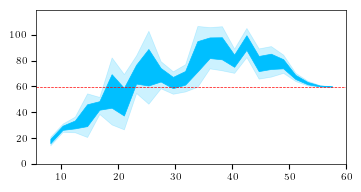

In [102]:
logXs = samples.logX().iloc[iterations]
plot_std(-logXs, -logXfs, logXfs_set, -true_logXf, (0, 2))

In [39]:
beta_start = get_beta_start(points, ndead)
beta_end = get_beta_end(points, ndead)
beta_DKL = get_beta_DKL(points, ndead)
logbeta_start, logbeta_end, logbeta_DKL = np.log([beta_start, beta_end, beta_DKL])
betas = np.exp(np.linspace(logbeta_end, logbeta_start, 10))

In [52]:
dG = points.d_G(nsamples=10, beta=beta_DKL)
dG.mean(), dG.std()

(25.363230160896507, 1.5362586756281038)

In [51]:
dG_range = points.d_G(nsamples=25, beta=betas)
dG_range.mean(), dG_range.std()

(19.94478587965569, 11.623746909592148)

In [167]:
ndead = 17000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead)
beta = beta_DKL(points, ndead)
dG = points.set_beta(beta).d_G(25).values
dG_mean = np.mean(dG)
dG_std = np.std(dG)

logLd, Xd = logL[ndead:], X_mean[ndead:]
N = len(logLd)

In [168]:
Nset = 100
theta_ds = np.zeros(Nset)
for i, d in enumerate(theta_ds):
    X = generate_Xs(nk)
    theta_ds[i] = analytic_lm_params(logLd, X[ndead:], d0=1)[1]
theta_ds = theta_ds[~np.isnan(theta_ds)]

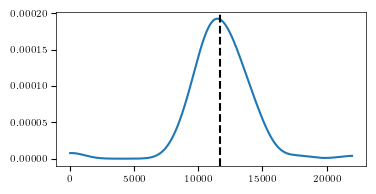

In [169]:
# Kernel density estimate of theta_ds
from scipy.stats import gaussian_kde
kde = gaussian_kde(theta_ds)
ds = np.linspace(0, theta_ds.max(), 1000)
def logkde(ds):
    return np.log(kde(ds))
theta_ds_kde = kde(ds)
plt.plot(ds, theta_ds_kde)
plt.axvline(x=np.median(theta_ds), color='k', ls='--')

In [172]:
theta_ds_filtered = theta_ds[abs(theta_ds - np.median(theta_ds)) < d_std]
theta_ds_filtered.mean(), theta_ds_filtered.std()

(11664.132272491675, 1030.6565752118854)

0.12642869244575736

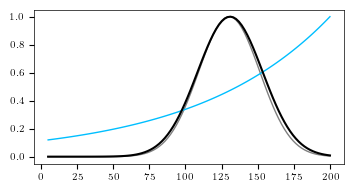

In [173]:
ds = np.linspace(5, 200, 100)
logp_dG = logprior(ds, dG_mean, dG_std)
logp_d = logprior(ds, theta_ds_filtered.mean(), theta_ds_filtered.std())

d_weight = dG_mean/theta_ds_filtered.std()
logpost = (logp_dG + d_weight*logp_d)/(1 + d_weight)
plt.plot(ds, np.exp(logp_dG - logp_dG.max()), lw=1, color='gray')
plt.plot(ds, np.exp(logp_d - logp_d.max()), lw=1, color='deepskyblue')

plt.plot(ds, np.exp(logpost - logpost.max()), color='black')
d_weight

In [174]:
d_infer = (np.exp(logpost - logpost.max()) * ds).sum() / np.exp(logpost - logpost.max()).sum()
d_infer_std = np.sqrt((np.exp(logpost - logpost.max()) * (ds - d_infer)**2).sum() / np.exp(logpost - logpost.max()).sum())
theta_infer_plus = params_from_d(logLd, Xd, d_infer + 2*d_infer_std)
theta_infer_minus = params_from_d(logLd, Xd, d_infer - 2*d_infer_std)

In [175]:
logL, X_mean, nk, logZdead = model.data(ndead)
plus = logXf_formula(theta_infer_plus, logZdead, X_mean[ndead])
minus = logXf_formula(theta_infer_minus, logZdead, X_mean[ndead])
minus, plus

(-63.92203662365601, -79.20712933920545)